# SeismoStats: How To
<div class="alert alert-block alert-info">

#### In this notebook we will show how to:

<ol>
    <li> Make a catalog object
    <ol>
        <li> by downloading it
        <li> by converting a csv file
    </ol>
    <li>Plot the seismicity</li>
    <li>Analyze the FMD</li>
    <ol>
         <li>Plot the FMD</li> 
        <li>Estimate the magnitude of completeness</li> 
        <li>Estimate b-values</li> 
    </ol>
    <li>Generate synthetic magnitudes</li>
    <li>Bin magnitudes</li>
</ol>

</div>

## 0. Import general packages

In [1]:
#%matplotlib widget
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Make a catalog object

<div class="alert alert-block alert-warning">
<font color=#208de2>     
The catalog object is a dataframe, with some additional methods and attributes.
The columns are:

|column header |type | importance|
|:-|:-|:-|
|latitude |float |required|
|longitude |float |required|
|depth| float| required|
|mag_type| string| optional|
|magnitude| float| required| 
|time| pandas timestamp| required|
|event_type| string| optional|
</font>
</div>

### 1.1 Download catalog

In [2]:
from seismostats.io.client import FDSNWSEventClient

<font color=#208de2> Start date and end date have to be defined as a datetime. In case something does not work out, the link to retrieve it manually is given back. </font>

In [3]:
start_time = pd.to_datetime('2020/01/01')
end_time = pd.to_datetime('2022/01/01')

min_longitude = 5
max_longitude = 11
min_latitude = 45
max_latitude = 48

min_magnitude = 0.5
url = 'http://arclink.ethz.ch/fdsnws/event/1/query'
client = FDSNWSEventClient(url)
df = client.get_events(
    start_time=start_time,
    end_time=end_time,
    min_magnitude=min_magnitude,
    min_longitude=min_longitude,
    max_longitude=max_longitude,
    min_latitude=min_latitude,
    max_latitude=max_latitude)

<font color=#208de2> The output is a catalog object</font>

In [4]:
df.tail()

,event_type,time,latitude,longitude,depth,evaluationmode,magnitude,magnitude_type,magnitude_MLhc,magnitude_MLh
2787,quarry blast,2020-01-03 14:43:49.025320,47.187560,7.185673,-683.593750,manual,1.213024,MLh,NaN,1.213023609
2788,earthquake,2020-01-03 14:28:09.701876,46.444436,9.104820,2033.203125,manual,0.596428,MLh,NaN,0.5964283368
2789,quarry blast,2020-01-02 08:47:20.725352,47.673434,7.585486,12113.281250,manual,0.657227,MLh,NaN,0.6572274734
2790,earthquake,2020-01-01 17:42:48.508164,46.031975,6.892110,5295.898438,manual,0.826313,MLh,NaN,0.8263128507
2791,earthquake,2020-01-01 13:43:47.626410,45.704174,7.068708,3302.734375,manual,0.824352,MLh,NaN,0.8243519995


### 1.2 Convert a dataframe into a catalog

## 2. Seismicity Plots

<div class="alert alert-block alert-warning">
<font color=#208de2>     
We have three basic plots of the seismicity

<ol>
<li>Seismicity in space</li>
<li>Cumulative count</li> 
<li>Magnitudes in time</li> 
</ol>

</font>
</div>

### 2.1. Plot in space

In [5]:
from seismostats import plot_in_space

<font color=#208de2>
It is possible to choose the resolutions 10, 50 and 110. Optionally you can choose the color scheme and the country of which you want to see the borders. For large areas/countries, the plotting can take some time.
</font>


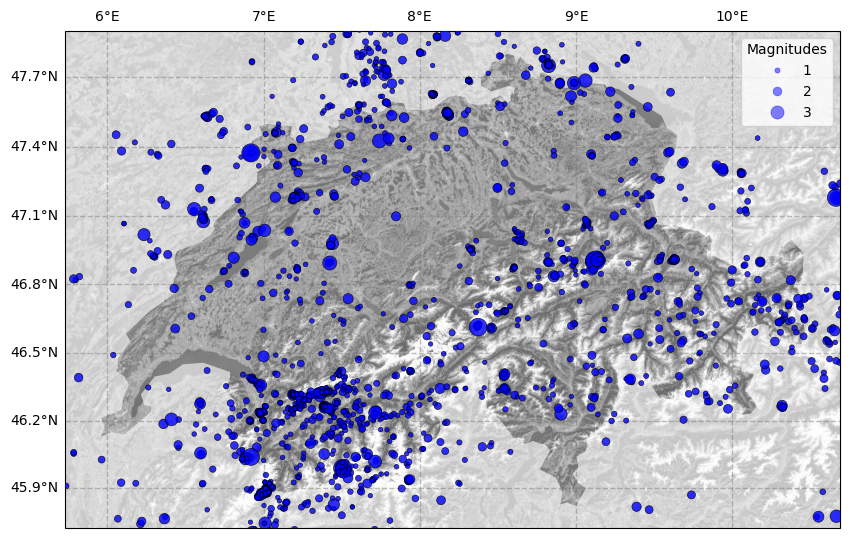

In [6]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, resolution='10m', include_map=True, country='Switzerland', colors='Greys_r', dot_labels=[1,2,3])

<font color=#208de2>
You can also choose the interpolation power and the size of the smallest and largest dot. 
</font>


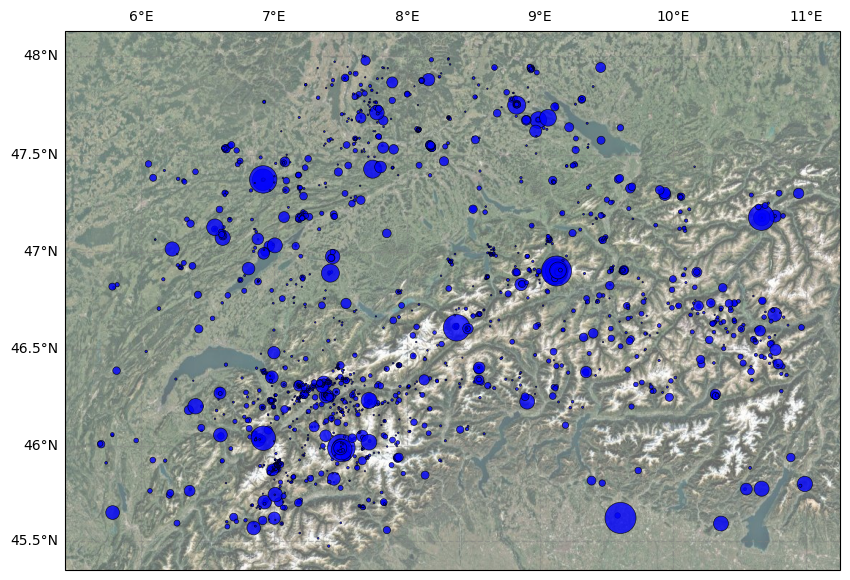

In [7]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, resolution='10m', include_map=True, dot_smallest=1, dot_largest=500, dot_interpolation_power=3, dot_labels=None)

<font color=#208de2>
The default is that the map is not included.
</font>

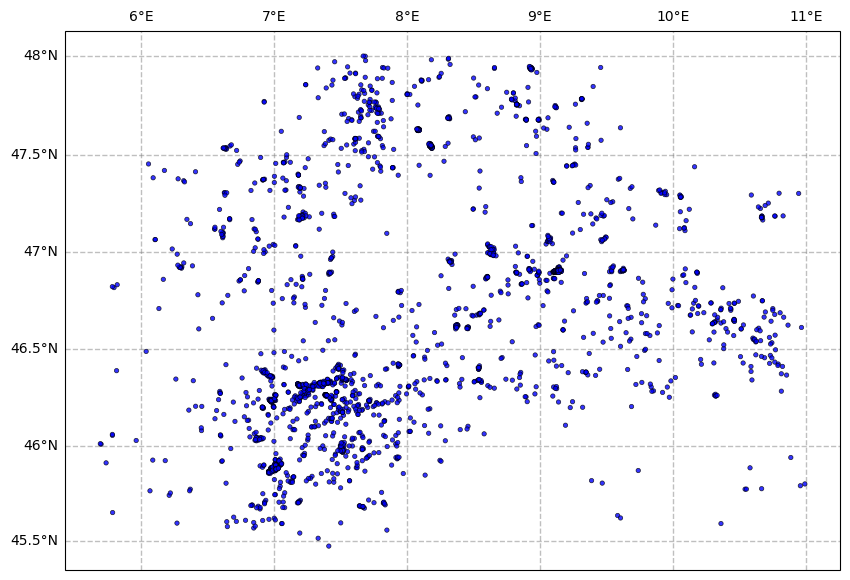

In [8]:
fig = plt.figure(figsize=(10, 10), linewidth=1)    
ax = plot_in_space(df, dot_smallest=0.1, dot_largest=10, dot_interpolation_power=0, dot_labels=False)

### 2.2. Plot in time

In [9]:
from seismostats import plot_cum_count, plot_mags_in_time

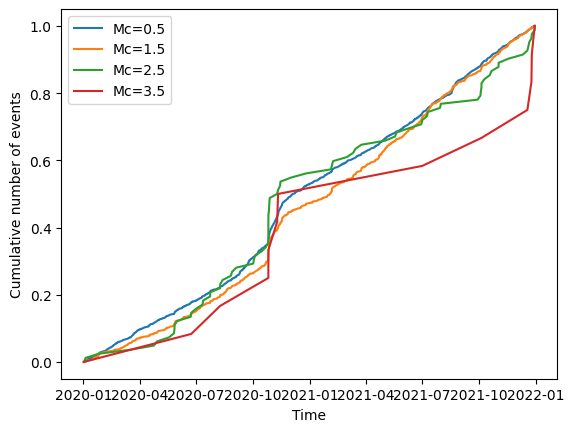

In [10]:
ax = plot_cum_count(df, mcs=np.arange(0.5, 4.0, 1), delta_m=0.1)

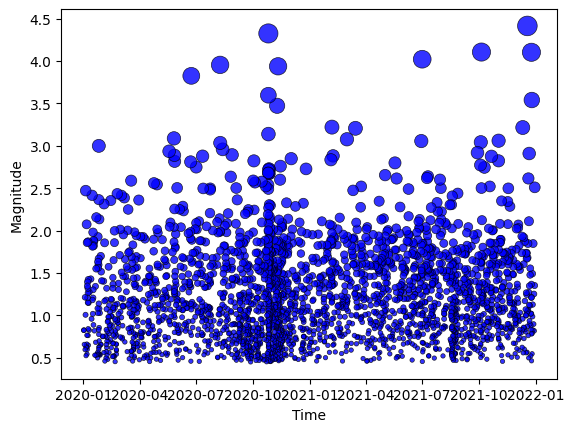

In [11]:
ax = plot_mags_in_time(df)

## 3. analysze the FMD

### 3.1 Plot magnitude distributions

In [12]:
from seismostats import plot_cum_fmd, plot_fmd

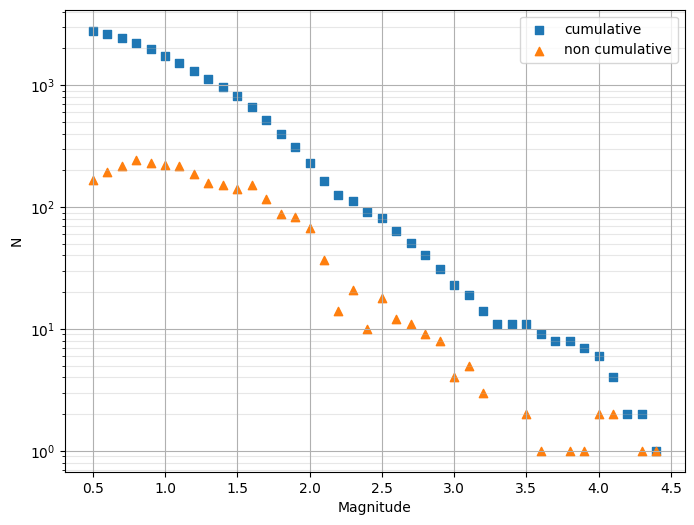

In [13]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax)
plot_fmd(df['magnitude'], ax=ax, grid=True)

plt.show()

### 3.2 Estimate completeness magnitude

In [14]:
from seismostats.analysis.estimate_mc import mc_ks, mc_max_curvature, mc_by_bvalue_stability
from seismostats.utils.binning import bin_to_precision

In [15]:
mc_stab, best_b, mcs_test, bs, diff_bs = mc_by_bvalue_stability(df['magnitude'], delta_m=0.01, stop_when_passed=True)
print(f'Stability method: Mc = {mc_stab:.2f}')

Stability method: Mc = 1.46


In [16]:
mc = mc_max_curvature(df['magnitude'], delta_m=0.1)
print(f'Maximum curvature method: Mc = {mc:.1f}')

Maximum curvature method: Mc = 1.0


In [17]:
mc_kstest, beta_kstest, mcs_tested, betas, ks_ds, ps = mc_ks(
    bin_to_precision(df['magnitude'], 0.1),
    delta_m=0.1,
    p_pass=0.1,
) 

print(f"KS test method:")
print("Tested Mc values:", mcs_tested)
print("First Mc to pass the KS test:", mc_kstest)
print(f"Associated beta value: {beta_kstest:.2f}")

KS test method:
Tested Mc values: [np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(1.1), np.float64(1.2), np.float64(1.3), np.float64(1.4), np.float64(1.5), np.float64(1.6), np.float64(1.7), np.float64(1.8), np.float64(1.9), np.float64(2.0), np.float64(2.1)]
First Mc to pass the KS test: 2.1
Associated beta value: 2.01


This method takes longer, especially when the magnitude sample is large.

If Mc is known to be larger than a certain value, giving the Mc values that should be tested as an input can make the Mc estimation faster.

In [18]:
# if Mc is known to be larger than or equal to 1.0

mc_kstest, beta_kstest, mcs_tested, betas, ks_ds, ps = mc_ks(
    bin_to_precision(df['magnitude'], 0.1),
    mcs_test=bin_to_precision(np.arange(1.0, 3.0, 0.1), 0.1),
    delta_m=0.1,
    p_pass=0.1,
) 

print("Tested Mc values:", mcs_tested)
print("First Mc to pass the KS test:", mc_kstest)
print(f"Associated beta value: {beta_kstest:.2f}")

Tested Mc values: [np.float64(1.0), np.float64(1.1), np.float64(1.2), np.float64(1.3), np.float64(1.4), np.float64(1.5), np.float64(1.6), np.float64(1.7), np.float64(1.8), np.float64(1.9), np.float64(2.0), np.float64(2.1)]
First Mc to pass the KS test: 2.1
Associated beta value: 2.01


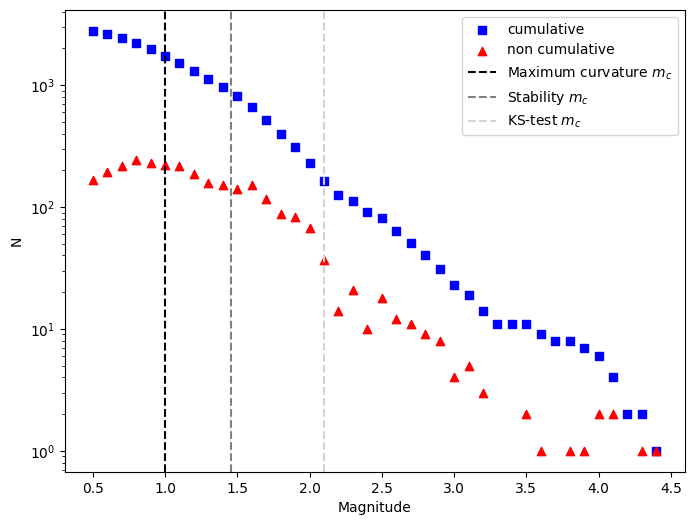

In [19]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax, color='blue')
plot_fmd(df['magnitude'], ax=ax, color='red')

plt.axvline(mc, color='black', linestyle='--', label='Maximum curvature $m_c$')
plt.axvline(mc_stab, color='grey', linestyle='--', label='Stability $m_c$')
plt.axvline(mc_kstest, color='lightgrey', linestyle='--', label='KS-test $m_c$')

plt.legend()
plt.show()

### 3.3 Estimate the b-value

In [20]:
from seismostats import estimate_b, bin_to_precision

In [21]:
delta_m = 0.1

In [22]:
mags = df['magnitude']
mags = bin_to_precision(mags, delta_m)


b_estimate, error = estimate_b(mags[mags>=mc], mc=mc, delta_m=delta_m, return_std=True, b_parameter='b_value')

b_estimate2, error = estimate_b(mags[mags>=mc_kstest], mc=mc_kstest, delta_m=delta_m, return_std=True, b_parameter='b_value')

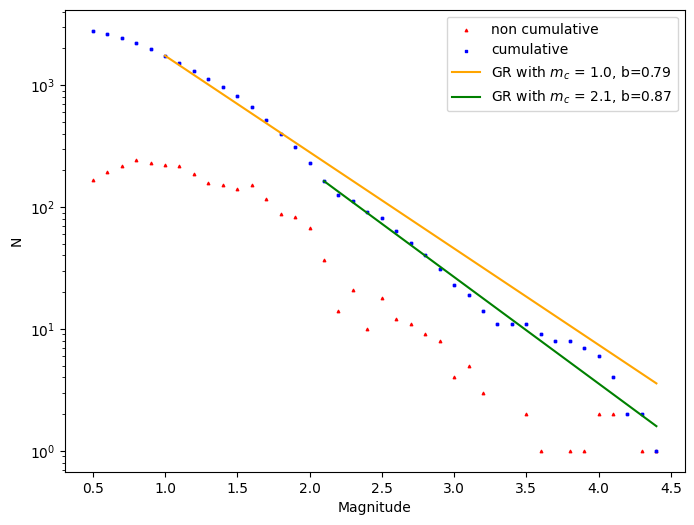

In [23]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_fmd(df['magnitude'], ax=ax, color='red', size=3)

plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax, color=['blue', 'orange'], b_value=b_estimate, mc=mc, 
             size=3, legend=['cumulative', r'GR with $m_c$ = {:.1f}'.format(mc)])
plot_cum_fmd(df['magnitude'], delta_m=0.1, ax=ax, b_value=b_estimate2, mc=mc_kstest, color = ['blue', 'green'], 
             size=3, legend=['_', r'GR with $m_c$ = {:.1f}'.format(mc_kstest)])

plt.show()


## 4. Generate and bin synthetic earthquakes

<div class="alert alert-block alert-warning">
<font color=#208de2>     
First we need to define the number of earthquakes, the b-value and the completeness magnitude. If binnning is applied, it is important to generate the magnitudes half a bin smaller than the smallest magnitude, otherwise the first bin will contain only half the events. For the b-value, note that beta is defined as the natural logarithm equivalent of the b-value.
</font>
</div>

In [24]:
from seismostats import simulate_magnitudes, bin_to_precision
import numpy as np

In [25]:
n = 200
b_value = 1
beta = b_value*np.log(10)
delta_m = 0.1
mc = 3
mc_generation = mc - delta_m / 2

<font color=#208de2> Now we can generate a synthetic magnitude distribution: </font>

In [26]:
mags = simulate_magnitudes(n,beta,mc_generation)
mags_binned = bin_to_precision(mags, delta_m)

<font color=#208de2> In order to bin the magnitudes, we just need to define the step-size: </font>

In [27]:
b_estimate, error = estimate_b(mags_binned, mc=mc, delta_m=delta_m, return_std=True, b_parameter='b_value')

<font color=#208de2> We can plot the original and binned magnitudes and their respective b-value estimates now. Note that we choose the bin position to be left in order to align the binned and the original magnitudes. </font>

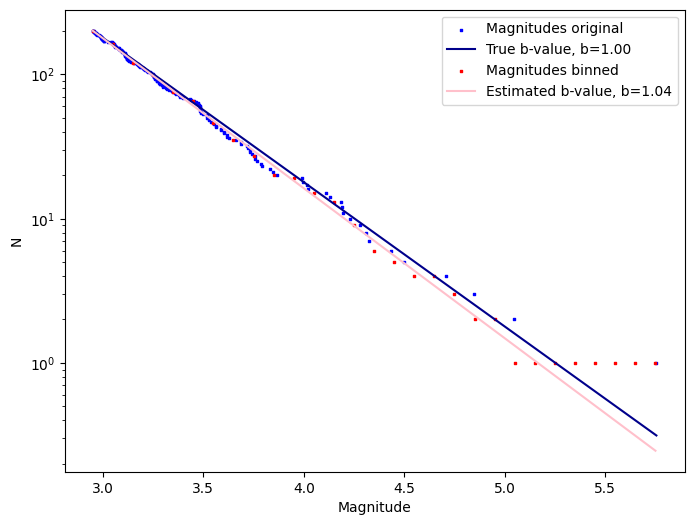

In [28]:
ax = plt.subplots(figsize=(8, 6))[1]

plot_cum_fmd(mags, ax=ax, b_value=b_value, mc=mc - delta_m/2, 
             color=['blue', 'darkblue'], legend=['Magnitudes original', 'True b-value'], size=3)
plot_cum_fmd(mags_binned,ax=ax, b_value=b_estimate, delta_m=delta_m, color=['red', 'pink'],
             bin_position='left', legend=['Magnitudes binned', 'Estimated b-value'], size=3)

plt.show()